# 07-1 인공 신경망
딥러닝과 인공 신경망 알고리즘을 이해하고 텐서플로를 사용해 간단한 인공 신경망 모델을 만들어 봅니다.

## 패션 MNIST

In [1]:
from tensorflow import keras
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [2]:
print(train_input.shape, train_target.shape)
print(test_input.shape, test_target.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


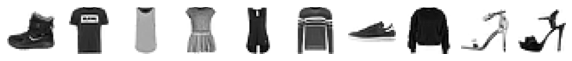

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


In [3]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 10, figsize=(10,10))
for i in range(10):
  axs[i].imshow(train_input[i], cmap='gray_r')
  axs[i].axis('off')
plt.show()

print([train_target[i] for i in range(10)])
# 0 티셔츠 / 1 바지 / 2 스웨터 / 3 드레스 / 4 코트 / 5 샌달 / 6 셔츠 / 7 스니커즈 / 8 가방 / 9 앵클 부츠

In [5]:
import numpy as np
print(np.unique(train_target, return_counts=True))
# 0~9까지 레이블마다 정확히 6000개의 샘플이 들어 있는 것을 확인할 수 있다.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


## 로지스틱 회귀로 패션 아이템 분류하기
이 훈련 샘플은 6만개나 되기 때문에 전체 데이터를 한꺼번에 사용하여 모델을 훈련하는 것보다 샘플을 하나씩 꺼내서 모델을 훈련하는 방법이 더 효율적일 수 있다.

확률적 경사 하강법은 여러 특성 중 기울기가 가장 가파른 방향을 따라 이동한다. 만약 특성마다 값의 범위가 많이 다르면 올바르게 손실 함수의 경사를 내려 오는데 어려움이 있을 수 있다. 따라서 패션 MNIST의 경우 각 픽셀이 0-255 사이의 정수값을 가지는데, 이를 0-1 사이의 값으로 정규화한다. 이는 표준화는 아니지만 양수 값으로 이루어진 이미지를 전처리할 때 널리 사용하는 방법이다.

In [7]:
train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1, 28*28)
# SGDClassifier는 2차원 입력을 다루지 못하기 때문에 각 샘플을 1차원 배열로 만들어야 한다.

print(train_scaled.shape)

(60000, 784)


In [8]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier
sc = SGDClassifier(loss='log', max_iter=5, random_state=42)
scores = cross_validate(sc, train_scaled, train_target, n_jobs=-1) #246p, 267p 참고
print(np.mean(scores['test_score']))

0.8195666666666668


## 인공 신경망
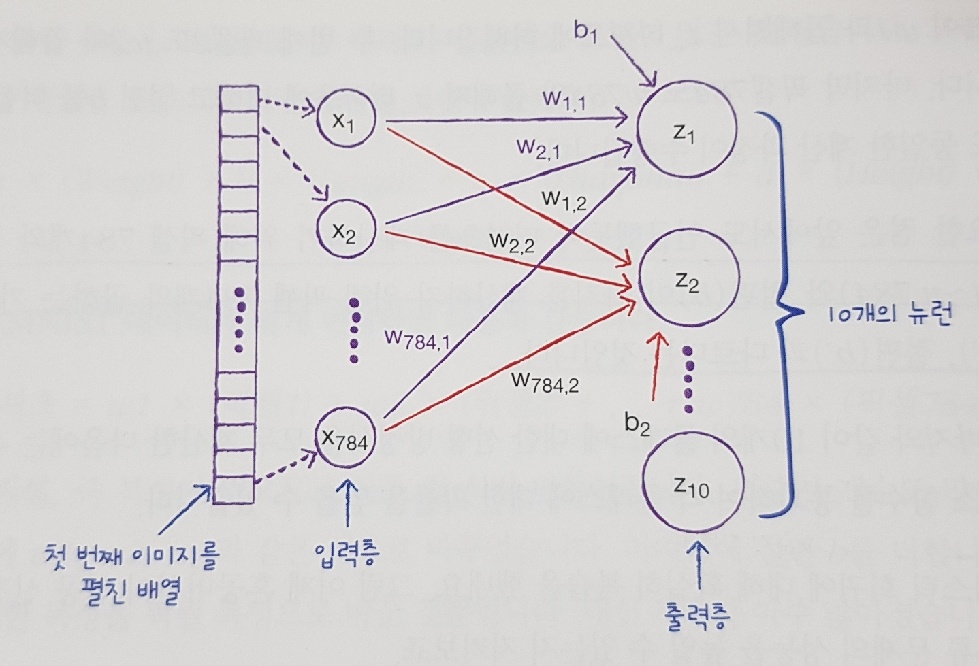


입력층과 출력층으로 이루어짐

출력층에서의 z 값을 계산하는 단위를 뉴런(유닛)이라고 한다. 

z을 만들기 위해 각 입력층에서의 값(x)과 가중치(w)를 각각 곱하고 그것을 더함 : z = sum(w*x)+b

### 텐서플로와 케라스
- 텐서플로 : 구글이 공개한 딥러닝 라이브러리
- 케라스 : 텐서플로의 고수준 API

## 인공 신경망으로 모델 만들기
로지스틱 회귀에서는 교차 검증을 사용해 모델을 평가했지만, 인공 신경망에서는 교차 검증을 잘 사용하지 않고 검증 세트를 별도로 덜어내어 사용한다.

1. 딥러닝 분야의 데이터셋은 충분히 크기 때문에 검증 점수가 안정적이고
2. 교차 검증을 수행하기에는 훈련 시간이 너무 오래 걸리기 때문

In [9]:
from sklearn.model_selection import train_test_split
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [10]:
print(train_scaled.shape, train_target.shape)
print(val_scaled.shape, val_target.shape)

(48000, 784) (48000,)
(12000, 784) (12000,)


In [11]:
dense = keras.layers.Dense(10, activation='softmax', input_shape=(784,))
# 양쪽의 뉴런이 모두 연결하고 있기 때문에 '완전 연결층'이라고도 불린다.

# 케라스의 Dense 클래스를 사용해 밀집층을 만듦. 필요한 매개변수는 (뉴런 개수, 뉴런의 출력에 적용할 함수, 입력의 크기)이다
# 뉴런 개수 = 10 : 10개의 패션 아이템을 분류하기 때문
# 뉴런에서 출력되는 값을 확률로 바꾸기 위해서는 소프트맥스 함수 사용

In [12]:
model= keras.Sequential(dense)

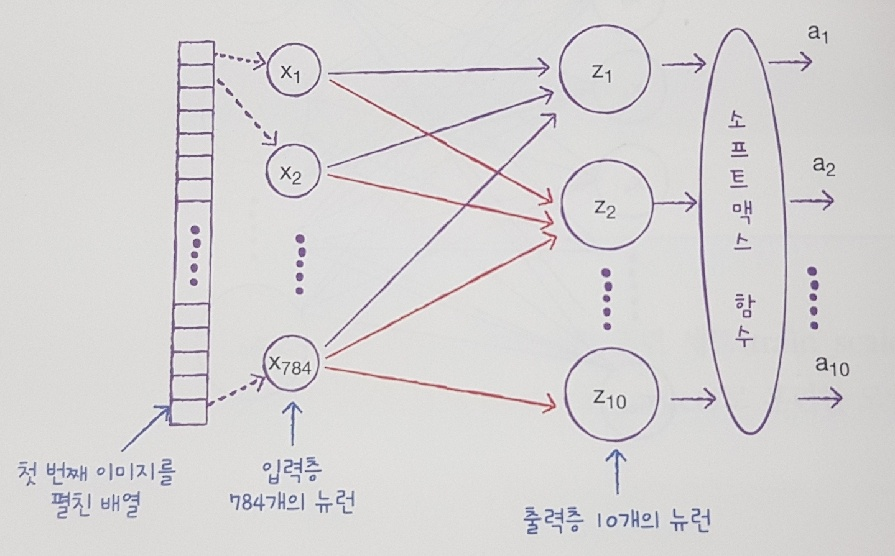

## 인공 신경망으로 패션 아이템 분류하기

In [13]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
# 케라스 모델은 훈련하기 전에 설정 단계가 있음. 이런 설정을 model 객체의 compile() 메서드에서 수행함.
# 손실 함수의 종류를 지정하고, 훈련 과정에서 계산하고 측정값을 지정해야한다.
# 이진 분류 : 이진 크로스 엔트로피 손실 함수
# 다중 분류 : 크로스 엔트로피 손실 함수

In [14]:
print(train_target[:10])
# 텐서플로에서는 정수로 된 타깃값을 원-핫 인코딩으로 바꾸지 않고 그냥 사용할 수 있음
# 정수로된 타깃값을 사용해 크로스 엔트로피 손실을 계산하는 것이 바로 'sparse_categorical_crossentropy'이다.
# 빽빽한 배열 말고 정수값 하나만 사용한다는 뜻에서 sparse(희소)라는 이름을 붙인 것으로 예상

[7 3 5 8 6 9 3 3 9 9]


In [15]:
model.fit(train_scaled, train_target, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6074 - accuracy: 0.7933
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4806 - accuracy: 0.8391
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4567 - accuracy: 0.8460
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4454 - accuracy: 0.8516
Epoch 5/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4369 - accuracy: 0.8552


In [16]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.4535 - accuracy: 0.8469


[0.4534924626350403, 0.846916675567627]